# QuillBot performance evaluation based on sentiment analysis, text similarity, and readability index.

In this notebook, we will be evaluating [QuillBot](https://quillbot.com/), an AI paraphrasing tool. QuillBot is a great tool for writing, but we would like to know if it can be used for improving readability and reducing text complexity.

We will be using following metrics and tools for the evaluation.

#### Sentiment Analysis
- Polarity and subjectivity: TextBlob, a popular NLP library based on NTLK.

#### Text Similarity
- Levenshtein distance: RapidFuzz, a python library for comparing string similarity.
- Semantic similarity: SpaCy, an industry-standard NLP library for comparing semantic (parts of speech) similarity.

#### Readability Index
- Readability: Readability Formulas, a website that offers free automatic readability checker.

In short, sentiment analysis and text similarity evaluate the robustness of the tool and readability index evaluates the performance.

We'll first install and import necessary modules and models.

In [0]:
!pip install rapidfuzz
!python3 -m spacy download en_core_web_lg

In [0]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from rapidfuzz import fuzz

import en_core_web_lg
plt.style.use('seaborn-notebook')

In [0]:
nltk.download("punkt")
nlp = en_core_web_lg.load()

## Paraphrased Dataset
The dataset has <b>The Truman Doctrine by Harry S. Truman</b> in the CSV format where each row represents a sentence and the columns represent the type of the sentence.

<b>orignal</b> column has the exact sentences from the text.

<b>standard</b> column has paraphrased sentences with the standard option.

<b>fluency</b> column has paraphrased sentences with the fluency option.

The definition of standard and fluency options:
- standard: "A middle ground of changing the input and keeping the meaning"
- fluency: "Improves fluency and fixes grammatical mistakes"

The dataset has a total of 109 sentences.

In [4]:
truman = pd.read_csv("https://raw.githubusercontent.com/mingir2/quillbot/master/truman.csv")
truman

,original,standard,fluency
0,The gravity of the situation which confronts t...,The gravity of the crisis that faces the world...,The gravity of the situation facing the world ...
1,The foreign policy and the national security o...,The country's foreign policy and national secu...,This country's foreign policy and national sec...
2,"One aspect of the present situation, which I w...","One element of the current situation, which I ...","One aspect of the current situation, which I w..."
3,The United States has received from the Greek ...,The United States has issued an urgent request...,The United States has received an urgent appea...
4,Preliminary reports from the American Economic...,Preliminary reports from the American Economic...,Preliminary reports from the American Economic...
...,...,...,...
104,We must keep that hope alive.,We have to keep the dream alive.,We have to keep the dream alive.
105,The free peoples of the world look to us for s...,The world's free peoples look to us for help i...,The world's free peoples look to us for help i...
106,"If we falter in our leadership, we may endange...","If we falter in our leadership, we could endan...","If we falter in our leadership, we may endange..."
107,Great responsibilities have been placed upon u...,The rapid movement of events has placed great ...,The rapid movement of events has placed great ...


## Sentiment Analysis

We will be using TextBlob's sentiment analysis feature to analyze the polarity and subjectivity of each sentences. TextBlob is built with NLTK and based on this [article](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/):

"Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement."

"Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]."

In other words, polarity evaluates whether a sentence is positive or negative and subjectivity evaluates whether a sentence is objective or subjective.


In [0]:
# evalSentiment() takes in a DataFrame object as an input and returns a tuple of DataFrame objects (polarity, subjectivity)
def evalSentiment(df):
  polarity, subjectivity = dict(), dict()

  for col in df.columns:
    polarity[col] = [TextBlob(s).polarity for s in df[col]]
    subjectivity[col] = [TextBlob(s).subjectivity for s in df[col]]

  return pd.DataFrame(polarity), pd.DataFrame(subjectivity)

polarity, subjectivity = evalSentiment(truman)

In [6]:
polarity.describe()

,original,standard,fluency
count,109.000000,109.000000,109.000000
mean,0.071241,0.069454,0.060876
std,0.250689,0.241434,0.238551
min,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,0.008333,0.000000,0.000000
75%,0.191667,0.178125,0.182143
max,1.000000,0.800000,1.000000


In [7]:
subjectivity.describe()

,original,standard,fluency
count,109.000000,109.000000,109.000000
mean,0.371470,0.352133,0.351254
std,0.295542,0.304093,0.298961
min,0.000000,0.000000,0.000000
25%,0.125000,0.033333,0.033333
50%,0.343750,0.333333,0.315000
75%,0.575000,0.516667,0.525000
max,1.000000,1.000000,1.000000


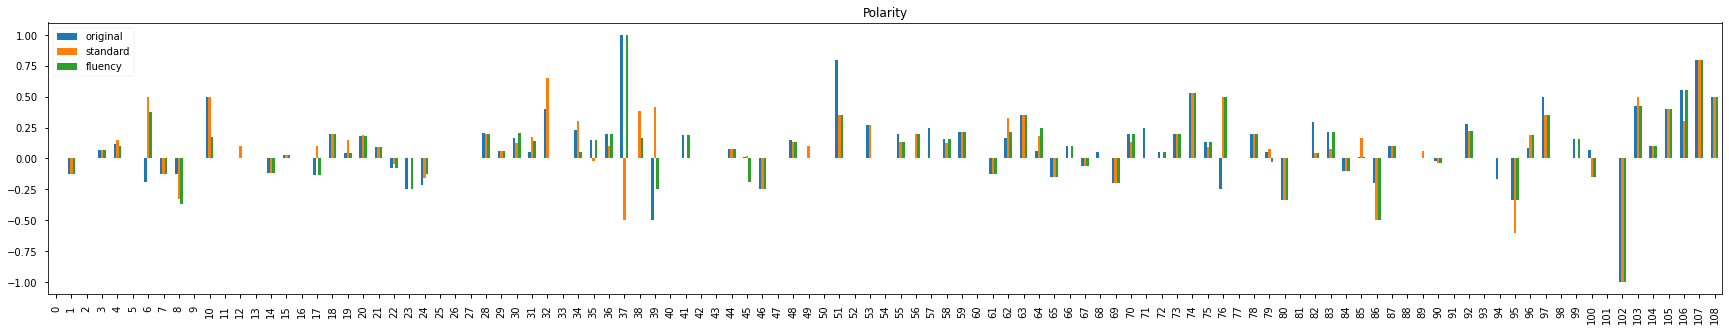

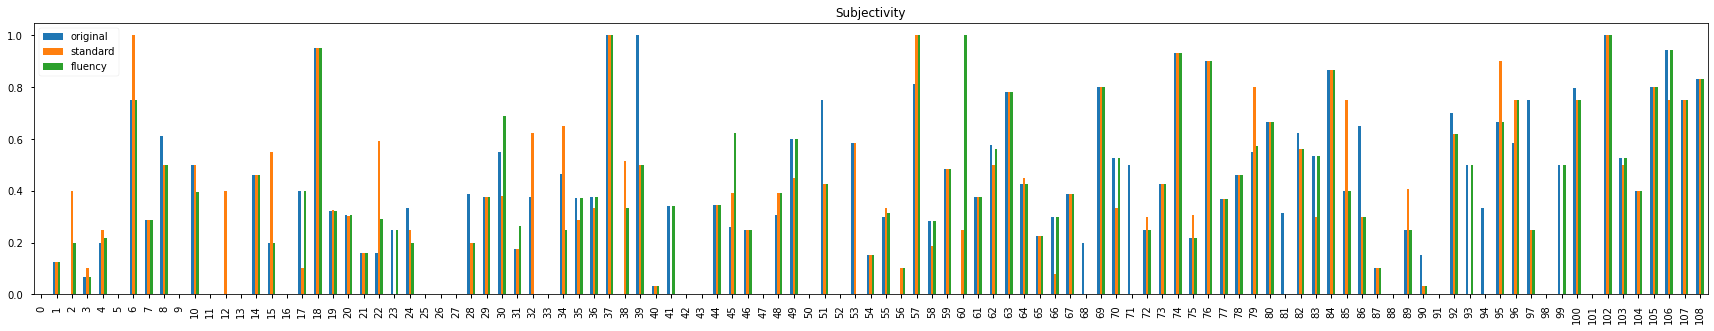

In [8]:
polarity.plot(title="Polarity", kind="bar", figsize=(30, 5))
subjectivity.plot(title="Subjectivity", kind="bar", figsize=(30, 5))

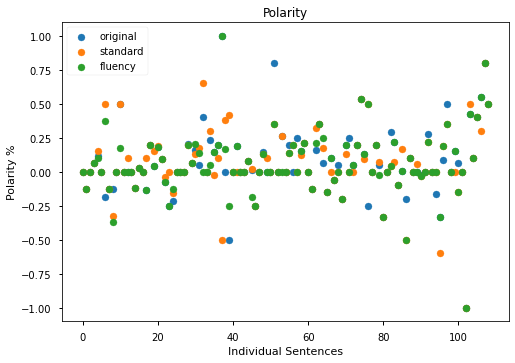

In [9]:
plt.scatter(x=polarity.index, y=polarity[polarity.columns[0]], label=polarity.columns[0])
plt.scatter(x=polarity.index, y=polarity[polarity.columns[1]], label=polarity.columns[1])
plt.scatter(x=polarity.index, y=polarity[polarity.columns[2]], label=polarity.columns[2])
plt.title("Polarity")
plt.xlabel("Individual Sentences")
plt.ylabel("Polarity %")
plt.legend()
plt.show()

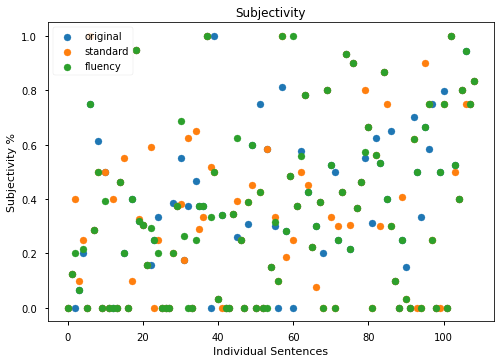

In [10]:
plt.scatter(x=subjectivity.index, y=subjectivity[subjectivity.columns[0]], label=subjectivity.columns[0])
plt.scatter(x=subjectivity.index, y=subjectivity[subjectivity.columns[1]], label=subjectivity.columns[1])
plt.scatter(x=subjectivity.index, y=subjectivity[subjectivity.columns[2]], label=subjectivity.columns[2])
plt.title("Subjectivity")
plt.xlabel("Individual Sentences")
plt.ylabel("Subjectivity %")
plt.legend()
plt.show()

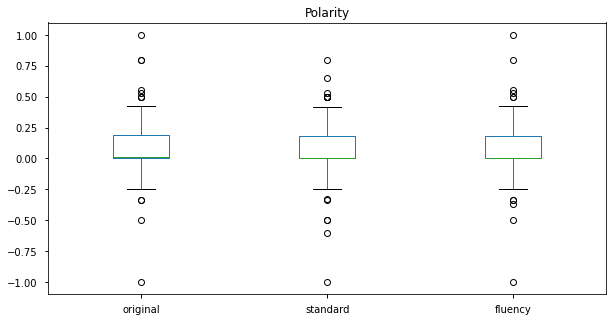

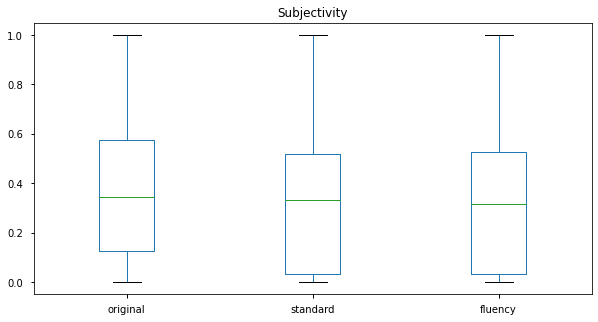

In [11]:
polarity.plot(title="Polarity", kind="box", figsize=(10, 5))
subjectivity.plot(title="Subjectivity", kind="box", figsize=(10, 5))

## Text Similarity

We will be using two different approaches to evaluate text similarity of the sentences. 

### Levenshtein Distance
Levenshtein distance uses an algorithmic approach for caculating the difference between a pair of words or sentences. It is also known as edit distance.

### Semantic Similarity
Semantic similarity uses a statistical approach for estimating simiarity between a pair of words or sentences. For SpaCy, it is implemented based convolutional neural network (CNN) model. We will be using the largest model available (en_core_web_lg).

In [0]:
def evalSimilarity(df, baseline):
  levenshtein, semantic = dict(), dict()

  columns = filter((lambda x: x != baseline), df.columns)
  for col in columns:
    levenshtein[col] = [fuzz.ratio(df[baseline][i], df[col][i]) for i in range(len(df[baseline]))]
    semantic[col] = [nlp(df[baseline][i]).similarity(nlp(df[col][i])) for i in range(len(df[baseline]))]

  return pd.DataFrame(levenshtein), pd.DataFrame(semantic)
levenshtein, semantic = evalSimilarity(truman, "original")

In [13]:
levenshtein.describe()

,standard,fluency
count,109.000000,109.000000
mean,74.830977,85.018500
std,11.535074,10.718848
min,44.897961,44.897961
25%,68.913857,78.820374
50%,75.210793,87.500000
75%,82.200645,93.043480
max,99.393936,99.619766


In [14]:
semantic.describe()

,standard,fluency
count,109.000000,109.000000
mean,0.979791,0.986701
std,0.017664,0.012053
min,0.901111,0.940164
25%,0.973698,0.981163
50%,0.986214,0.991234
75%,0.991480,0.994587
max,1.000000,1.000000


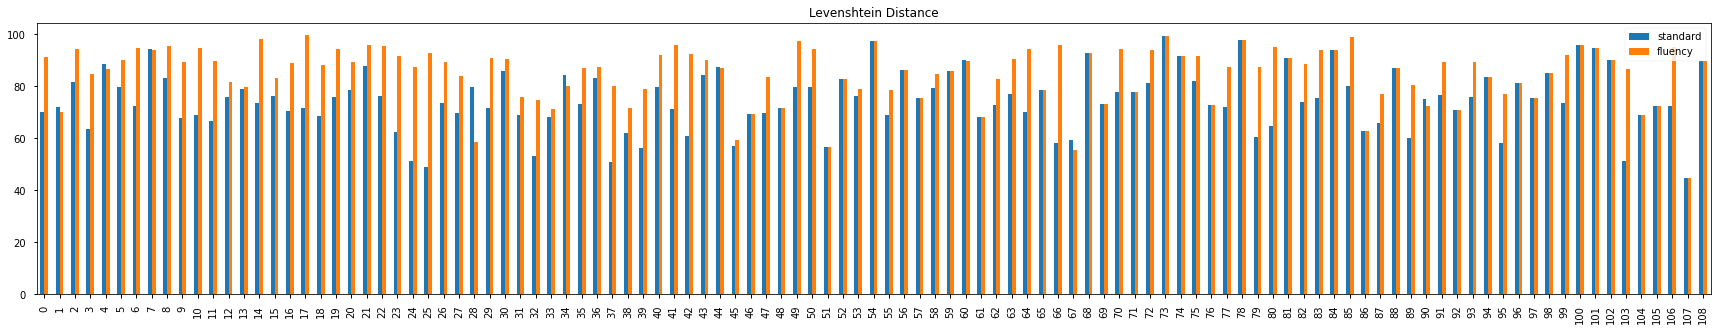

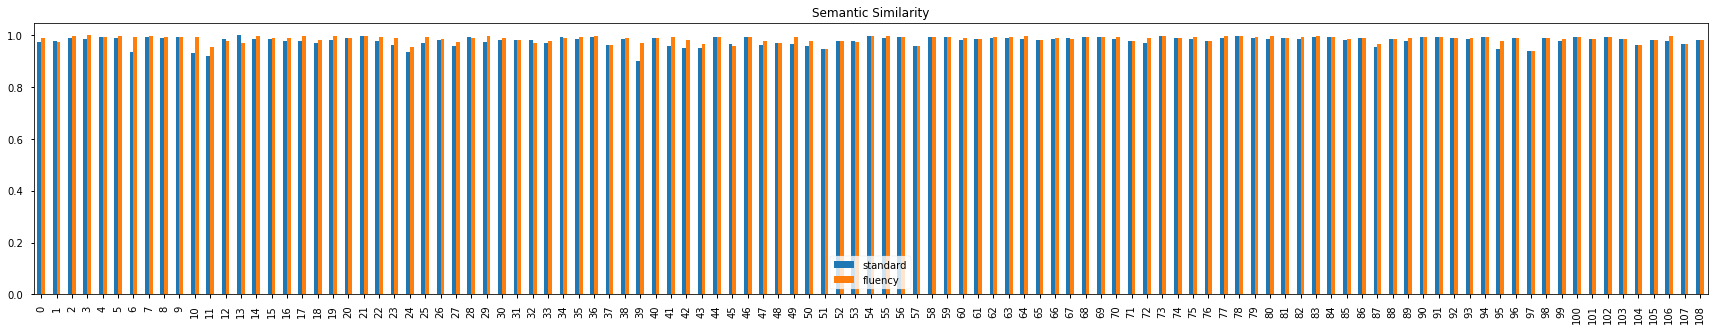

In [15]:
levenshtein.plot(title="Levenshtein Distance", kind="bar", figsize=(30, 5))
semantic.plot(title="Semantic Similarity", kind="bar", figsize=(30, 5))

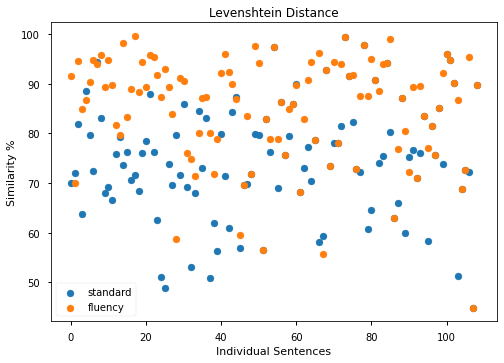

In [16]:
plt.scatter(x=levenshtein.index, y=levenshtein[levenshtein.columns[0]], label=levenshtein.columns[0])
plt.scatter(x=levenshtein.index, y=levenshtein[levenshtein.columns[1]], label=levenshtein.columns[1])
plt.title("Levenshtein Distance")
plt.xlabel("Individual Sentences")
plt.ylabel("Similarity %")
plt.legend()
plt.show()

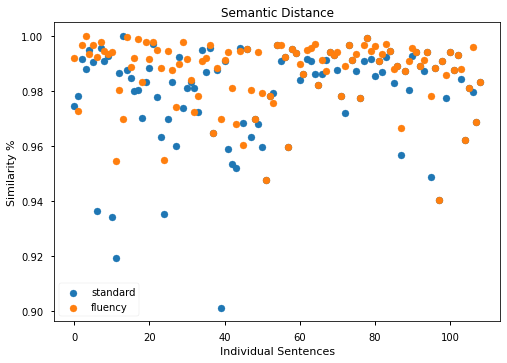

In [17]:
plt.scatter(x=semantic.index, y=semantic[semantic.columns[0]], label=semantic.columns[0])
plt.scatter(x=semantic.index, y=semantic[semantic.columns[1]], label=semantic.columns[1])
plt.title("Semantic Distance")
plt.xlabel("Individual Sentences")
plt.ylabel("Similarity %")
plt.legend()
plt.show()

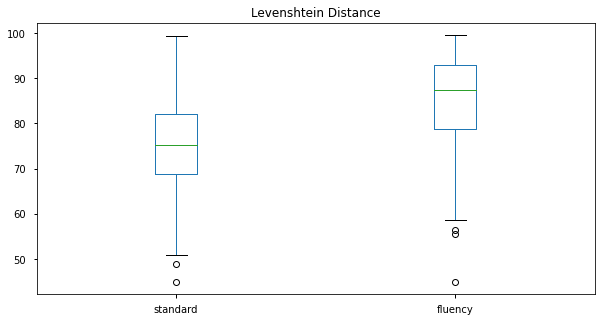

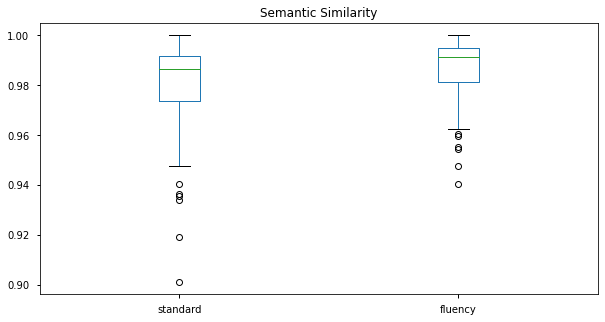

In [18]:
levenshtein.plot(title="Levenshtein Distance", kind="box", figsize=(10, 5))
semantic.plot(title="Semantic Similarity", kind="box", figsize=(10, 5))

## Readability Index

We will using a free web tool called [Readability Formulas](https://readabilityformulas.com/) to evaluate the readability (reading level) of the text. Readability Index is a category of heuristic methods for evaluating reading level and grade level of a text.

The formulas:
1. The Flesch Reading Ease formula
2. The Flesch-Kincaid Grade Level
3. The Fog Scale (Gunning FOG Formula)
4. The SMOG Index
5. The Coleman-Liau Index
6. Automated Readability Index
7. Linsear Write Formula


### Original
```
Flesch Reading Ease score: 47 (text scale)
Flesch Reading Ease scored your text: difficult to read.

Gunning Fog: 14.6 (text scale)
Gunning Fog scored your text: hard to read.

Flesch-Kincaid Grade Level: 11.7
Grade level: Twelfth Grade.

The Coleman-Liau Index: 11
Grade level: Eleventh Grade

The SMOG Index: 11.2
Grade level: Eleventh Grade

Automated Readability Index: 12
Grade level: 17-18 yrs. old (Twelfth graders)

Linsear Write Formula : 13.9
Grade level: College.
```

### Standard
```
Flesch Reading Ease score: 48.2 (text scale)
Flesch Reading Ease scored your text: difficult to read.

Gunning Fog: 14.1 (text scale)
Gunning Fog scored your text: hard to read.

Flesch-Kincaid Grade Level: 11.2
Grade level: Eleventh Grade.

The Coleman-Liau Index: 11
Grade level: Eleventh Grade

The SMOG Index: 10.9
Grade level: Eleventh Grade

Automated Readability Index: 11.3
Grade level: 15-17 yrs. old (Tenth to Eleventh graders)

Linsear Write Formula : 12.9
Grade level: College.
```

### Fluency
```
Flesch Reading Ease score: 48.8 (text scale)
Flesch Reading Ease scored your text: difficult to read.

Gunning Fog: 14.3 (text scale)
Gunning Fog scored your text: hard to read.

Flesch-Kincaid Grade Level: 11.3
Grade level: Eleventh Grade.

The Coleman-Liau Index: 11
Grade level: Eleventh Grade

The SMOG Index: 11.1
Grade level: Eleventh Grade

Automated Readability Index: 11.4
Grade level: 15-17 yrs. old (Tenth to Eleventh graders)

Linsear Write Formula : 13.4
Grade level: College.
```